In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('new_train.csv').to_numpy()
val_data = pd.read_csv('new_val.csv').to_numpy()
print(train_data.shape)
print(val_data.shape)


(4324, 22)
(1082, 22)


## Preprocess

In [3]:
general_train_np = train_data[:, [6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 19]].astype(float)
train_y_np = train_data[:, -1].astype(int)

#general_train_np[:, 7:10] = general_train_np[:, 7:10] / general_train_np[:, [6]]
#general_train_np[:, 5], fitted_lambda1 = boxcox(general_train_np[:, 5], lmbda=None)
#general_train_np[:, 6], fitted_lambda2 = boxcox(general_train_np[:, 6], lmbda=None)
#general_train_np = (general_train_np - np.mean(general_train_np, axis=0)) / np.std(general_train_np, axis=0)

general_val_np = val_data[:, [6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 19]].astype(float)
val_y_np = val_data[:, -1].astype(int)

#general_val_np[:, 7:10] = general_val_np[:, 7:10] / general_val_np[:, [6]]
#general_val_np[:, 5] = stats.boxcox(general_val_np[:, 5], fitted_lambda1)[0]
#general_val_np[:, 6] = stats.boxcox(general_val_np[:, 6], fitted_lambda2)[0]
#general_val_np = (general_val_np - np.mean(general_val_np, axis=0)) / np.std(general_val_np, axis=0)

# NN

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [6]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [13]:
class AdvancedNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AdvancedNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5)
        )
        
        self.layer4 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

In [8]:
train_tensor = torch.tensor(general_train_np, dtype=torch.float, device=device)
train_labels = torch.tensor(train_y_np[:, np.newaxis], dtype=torch.float, device=device)
print(train_tensor.shape)
print(train_labels.dtype)

val_tensor = torch.tensor(general_val_np, dtype=torch.float, device=device)
val_labels = torch.tensor(val_y_np[:, np.newaxis], dtype=torch.float, device=device)

train_dataset = TensorDataset(train_tensor, train_labels)
val_dataset = TensorDataset(val_tensor, val_labels)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.Size([4324, 11])
torch.float32


In [16]:
input_size = 11
num_classes = 1
model = SimpleNN(input_size, num_classes).to(cuda)
#model = AdvancedNN(input_size, num_classes)

learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 100

train_loss_list = []
val_loss_list = []
val_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}")
    train_loss_list.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = F.sigmoid(outputs.data) >= 0.5
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_dataloader)
    val_accuracy = correct / total
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

Epoch 1, Train Loss: 12150.025619058048
Epoch 1, Validation Loss: 13863.446138269761, Validation Accuracy: 0.4953789279112754
Epoch 2, Train Loss: 8826.566746880026
Epoch 2, Validation Loss: 1641.235735724954, Validation Accuracy: 0.5434380776340111
Epoch 3, Train Loss: 7519.65603390862
Epoch 3, Validation Loss: 8446.432495117188, Validation Accuracy: 0.5138632162661737
Epoch 4, Train Loss: 6764.3931604273175
Epoch 4, Validation Loss: 3582.528844496783, Validation Accuracy: 0.5739371534195934
Epoch 5, Train Loss: 10193.349797753726
Epoch 5, Validation Loss: 6303.82715920841, Validation Accuracy: 0.6940850277264325
Epoch 6, Train Loss: 5425.111172572107
Epoch 6, Validation Loss: 3394.44484576057, Validation Accuracy: 0.6404805914972274
Epoch 7, Train Loss: 3288.0159040619346
Epoch 7, Validation Loss: 1089.3148646635168, Validation Accuracy: 0.6931608133086876
Epoch 8, Train Loss: 2180.0763109431546
Epoch 8, Validation Loss: 1370.6115345674402, Validation Accuracy: 0.6136783733826248
Epo

Epoch 67, Train Loss: 0.5980340511921574
Epoch 67, Validation Loss: 0.6894070278195774, Validation Accuracy: 0.7486136783733827
Epoch 68, Train Loss: 0.606694458381218
Epoch 68, Validation Loss: 0.6021512685453191, Validation Accuracy: 0.7060998151571165
Epoch 69, Train Loss: 0.6063995455556056
Epoch 69, Validation Loss: 0.6151611340396544, Validation Accuracy: 0.7310536044362292
Epoch 70, Train Loss: 0.6517503248418078
Epoch 70, Validation Loss: 0.6605038677944857, Validation Accuracy: 0.6062846580406654
Epoch 71, Train Loss: 0.5945608979638886
Epoch 71, Validation Loss: 0.6710513795123381, Validation Accuracy: 0.6016635859519408
Epoch 72, Train Loss: 0.6190406914581271
Epoch 72, Validation Loss: 0.6087044819312937, Validation Accuracy: 0.755083179297597
Epoch 73, Train Loss: 0.5863211834255386
Epoch 73, Validation Loss: 0.7453553886974559, Validation Accuracy: 0.7763401109057301
Epoch 74, Train Loss: 0.5971124415450236
Epoch 74, Validation Loss: 0.6072233617305756, Validation Accurac

## NN visuals

In [20]:
def plot_metrics(train_loss, val_loss, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

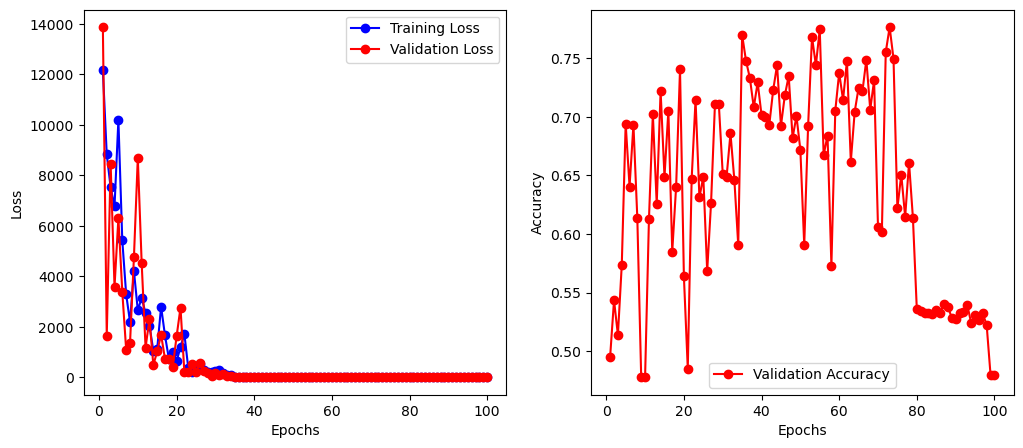

In [18]:
plot_metrics(train_loss_list, val_loss_list, val_accuracy_list)

In [25]:
general_train_np = train_data[:, [6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 19]].astype(float)
train_y_np = train_data[:, -1].astype(int)

general_train_np[:, 7:10] = general_train_np[:, 7:10] / general_train_np[:, [6]]
#general_train_np[:, 5], fitted_lambda1 = boxcox(general_train_np[:, 5], lmbda=None)
#general_train_np[:, 6], fitted_lambda2 = boxcox(general_train_np[:, 6], lmbda=None)
general_train_np = (general_train_np - np.mean(general_train_np, axis=0)) / np.std(general_train_np, axis=0)

general_val_np = val_data[:, [6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 19]].astype(float)
val_y_np = val_data[:, -1].astype(int)

general_val_np[:, 7:10] = general_val_np[:, 7:10] / general_val_np[:, [6]]
#general_val_np[:, 5] = stats.boxcox(general_val_np[:, 5], fitted_lambda1)[0]
#general_val_np[:, 6] = stats.boxcox(general_val_np[:, 6], fitted_lambda2)[0]
general_val_np = (general_val_np - np.mean(general_val_np, axis=0)) / np.std(general_val_np, axis=0)

In [26]:
train_tensor = torch.tensor(general_train_np[train_y_np == 1], dtype=torch.float, device=device)
train_labels = torch.tensor(train_y_np[train_y_np == 1][:, np.newaxis], dtype=torch.float, device=device)
print(train_tensor.shape)
print(train_labels.dtype)

val_tensor = torch.tensor(general_val_np, dtype=torch.float, device=device)
val_labels = torch.tensor(val_y_np[:, np.newaxis], dtype=torch.float, device=device)

train_dataset = TensorDataset(train_tensor, train_labels)
val_dataset = TensorDataset(val_tensor, val_labels)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.Size([2186, 11])
torch.float32


In [27]:
input_size = 11
num_classes = 1
model = SimpleNN(input_size, num_classes).to(device)
#model = AdvancedNN(input_size, num_classes)

learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 20

train_loss_list = []
val_loss_list = []
val_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}")
    train_loss_list.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = F.sigmoid(outputs.data) >= 0.5
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_dataloader)
    val_accuracy = correct / total
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

Epoch 1, Train Loss: 0.1566899566155305
Epoch 1, Validation Loss: 2.602608358158785, Validation Accuracy: 0.477818853974122
Epoch 2, Train Loss: 0.0030331751534148402
Epoch 2, Validation Loss: 3.37536718564875, Validation Accuracy: 0.477818853974122
Epoch 3, Train Loss: 0.0009852155884457886
Epoch 3, Validation Loss: 3.8205398952259735, Validation Accuracy: 0.477818853974122
Epoch 4, Train Loss: 0.0004870299076108073
Epoch 4, Validation Loss: 4.138634955181795, Validation Accuracy: 0.477818853974122
Epoch 5, Train Loss: 0.00028695595160504615
Epoch 5, Validation Loss: 4.389403406311484, Validation Accuracy: 0.477818853974122
Epoch 6, Train Loss: 0.00018918741019054627
Epoch 6, Validation Loss: 4.594783530515783, Validation Accuracy: 0.477818853974122
Epoch 7, Train Loss: 0.00013263616668721795
Epoch 7, Validation Loss: 4.771583795547485, Validation Accuracy: 0.477818853974122
Epoch 8, Train Loss: 9.839395299449266e-05
Epoch 8, Validation Loss: 4.924283672781551, Validation Accuracy: 0.

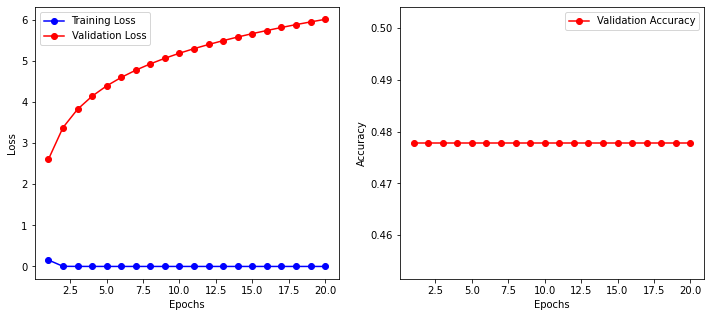

In [28]:
plot_metrics(train_loss_list, val_loss_list, val_accuracy_list)

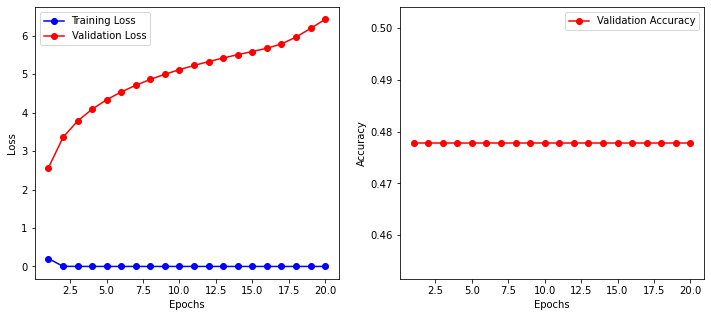

In [24]:
plot_metrics(train_loss_list, val_loss_list, val_accuracy_list)